# Image Caption Generator

## Introduction

Image Caption Generation is a complex AI task that bridges computer vision and NLP. The objective is to generate textual descriptions for images, requiring the model to both understand visual content and express it in coherent language.



The importance of this project lies in its wide applications, including improving accessibility for visually impaired individuals, automating media tagging, and enhancing human-AI interaction. Using the robust VGG16 architecture ensures accurate feature extraction, forming the foundation for generating meaningful and contextually relevant captions.

## Dataset

Flickr8k Dataset: Contains 8,091 images, each paired with five captions, totaling 40,455 descriptions.

Dataset Source: KAGGLE LINK https://www.kaggle.com/datasets/jaykumar2862/flicker-8k

# Model Details
VGG16: A pre-trained convolutional neural network, chosen for its high accuracy (92.7% top-5 on ImageNet) and ability to extract rich visual features.
Last layer removed to use the extracted features as input to a language generation model.

## Model Evaluation matrix

BLEU (Bilingual Evaluation Understudy)

BLEU Score: Measures the overlap between generated and reference captions, with values ranging from 0 (no overlap) to 1 (perfect match).

The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The comparison is made regardless of word order.

*The Python Natural Language Toolkit library, or NLTK, provides an implementation of the BLEU score that you can use to evaluate your generated text against a reference.*

# Importance
This project has significant applications in accessibility tools, automated content tagging, and enhanced human-computer interaction. By integrating VGG16 and NLP techniques, it aims to push the boundaries of AI's ability to describe and interpret visual data.

### Importing necessary libraries

In [8]:
import tensorflow as tf
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter
warnings.filterwarnings("ignore")

# Print versions
print("python {}".format(sys.version))
print("tensorflow version {}".format(tf.__version__))

# GPU Configuration for TensorFlow 2.x
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Optionally, limit GPU memory
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10240)]
        )
        print("GPU configured successfully.")
    except RuntimeError as e:
        print("Error configuring GPU:", e)

# Seed setting function
def set_seed(sd=123):
    from numpy.random import seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    tf.random.set_seed(sd)


python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
tensorflow version 2.16.2


### Downloading and importing dataset in the notebook

In [10]:

dir_Flickr_jpg = r"/Users/arjunpesaru/Desktop/sml_p/Flickr_Data/Flickr_Data/Images"
dir_Flickr_text = r"/Users/arjunpesaru/Desktop/sml_p/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


## Preliminary Analysis

#### Importing Caption data

Load the text data and save it into a panda dataframe df_txt.

In [12]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

# storing the data in a list called datatxt
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

# creating a df_txt dataframe which will keep the caption as below
df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")

# Counting number of captions for each image using counter
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [13]:
df_txt[:6]

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   
5  1001773457_577c3a7d70.jpg     0   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
5         a black dog and a spotted dog are fighting

### Example pictures with captions

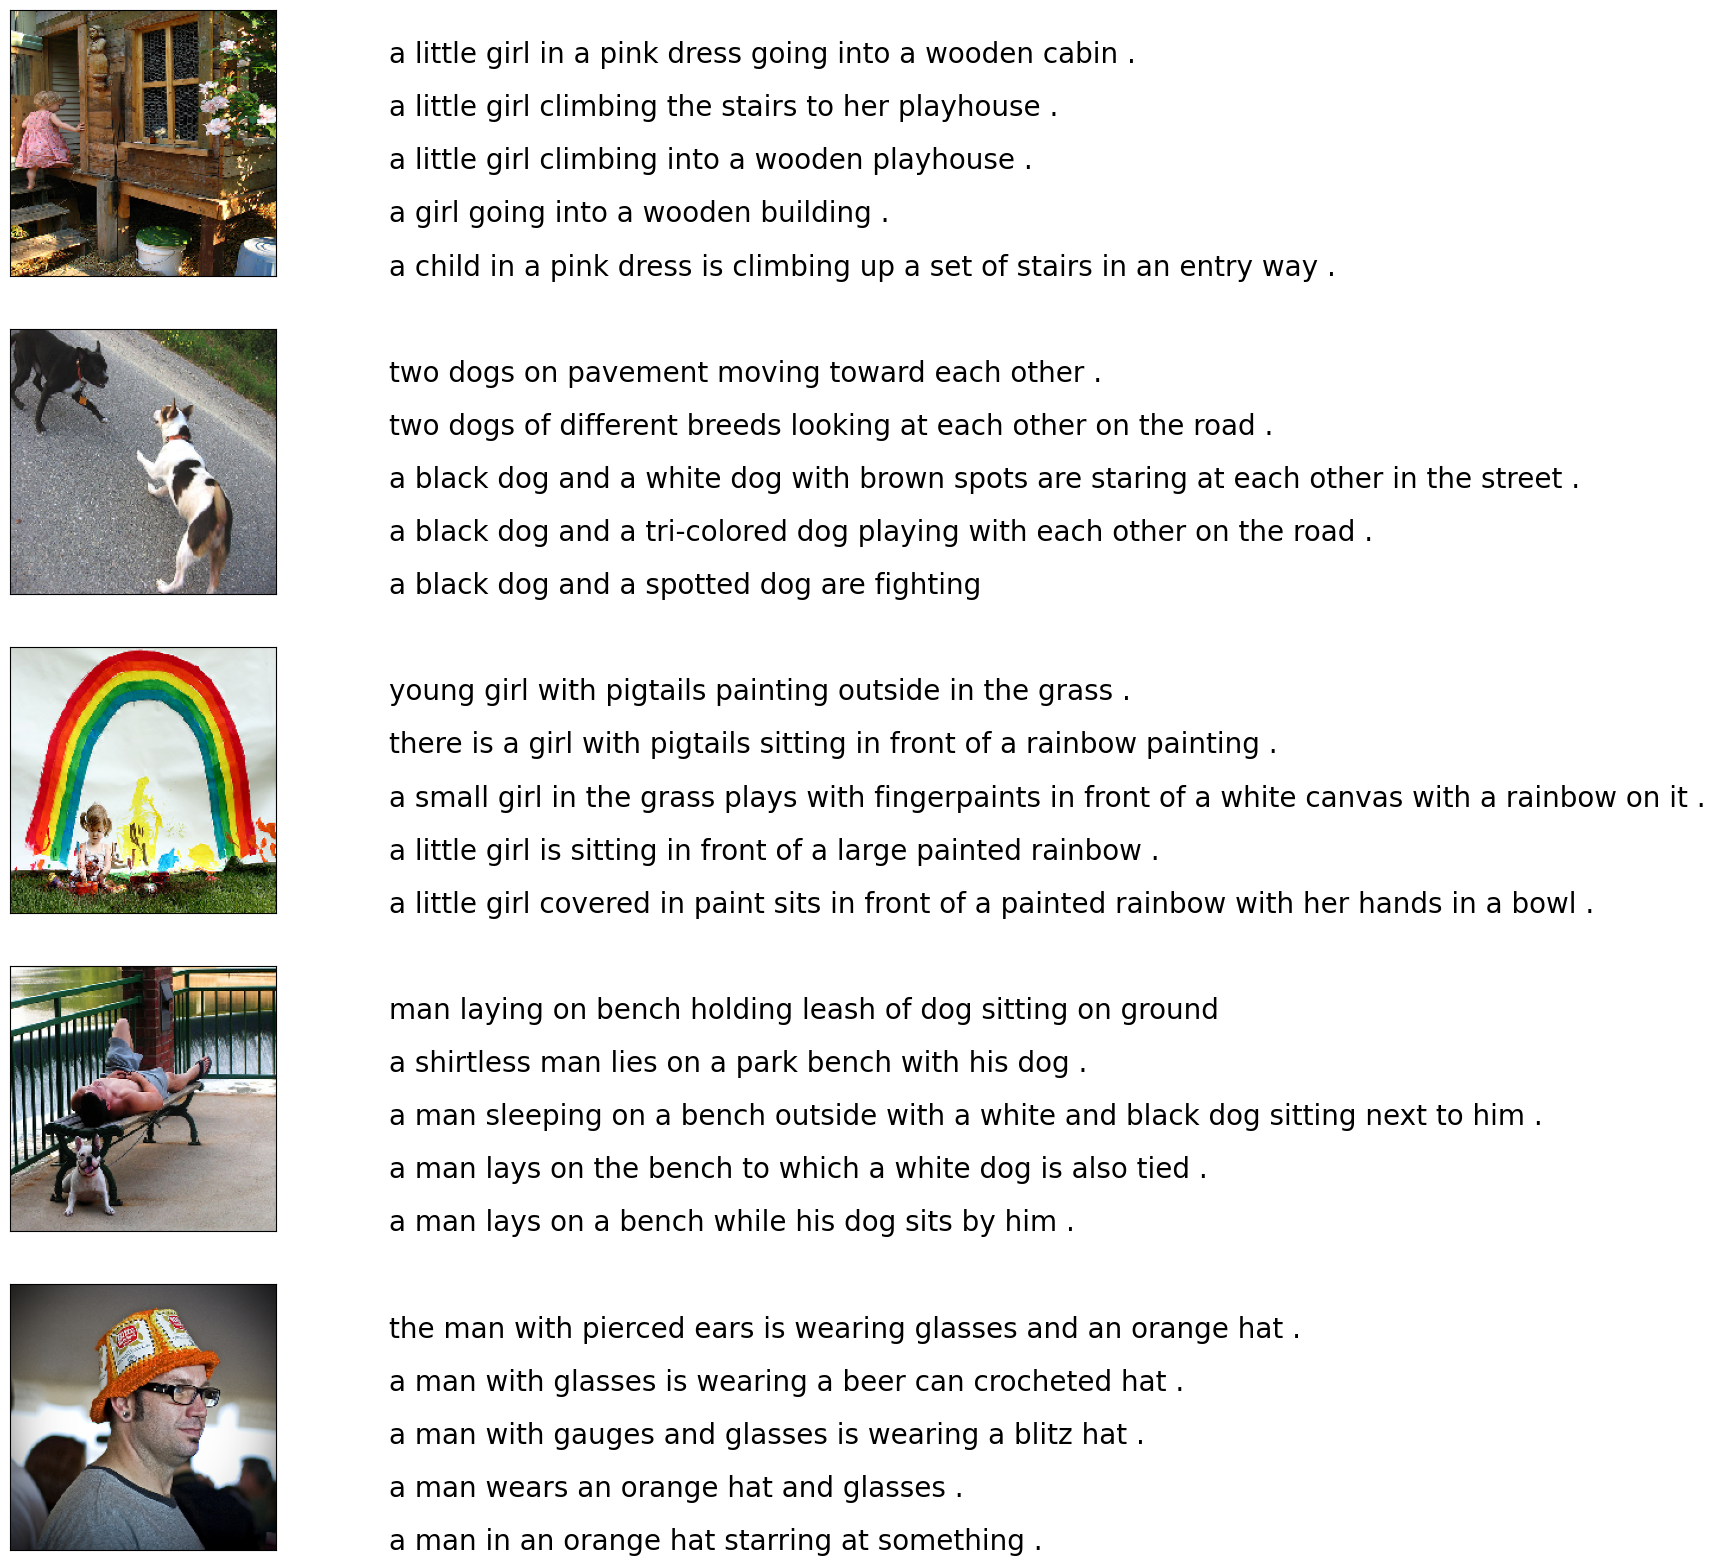

In [15]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Displaying (npic = 5) pics from the dataset
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Data Preparation

We create a new dataframe dfword to visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [18]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    dfword.sort_values(by='count', ascending=False, inplace=True)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975

#### The most and least frequently appearing words

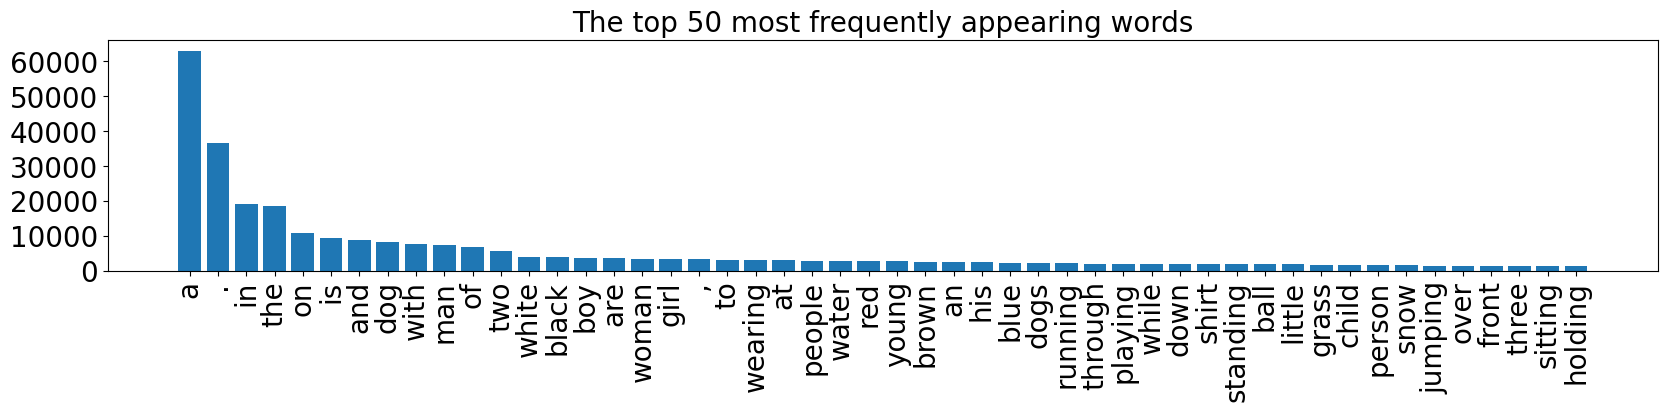

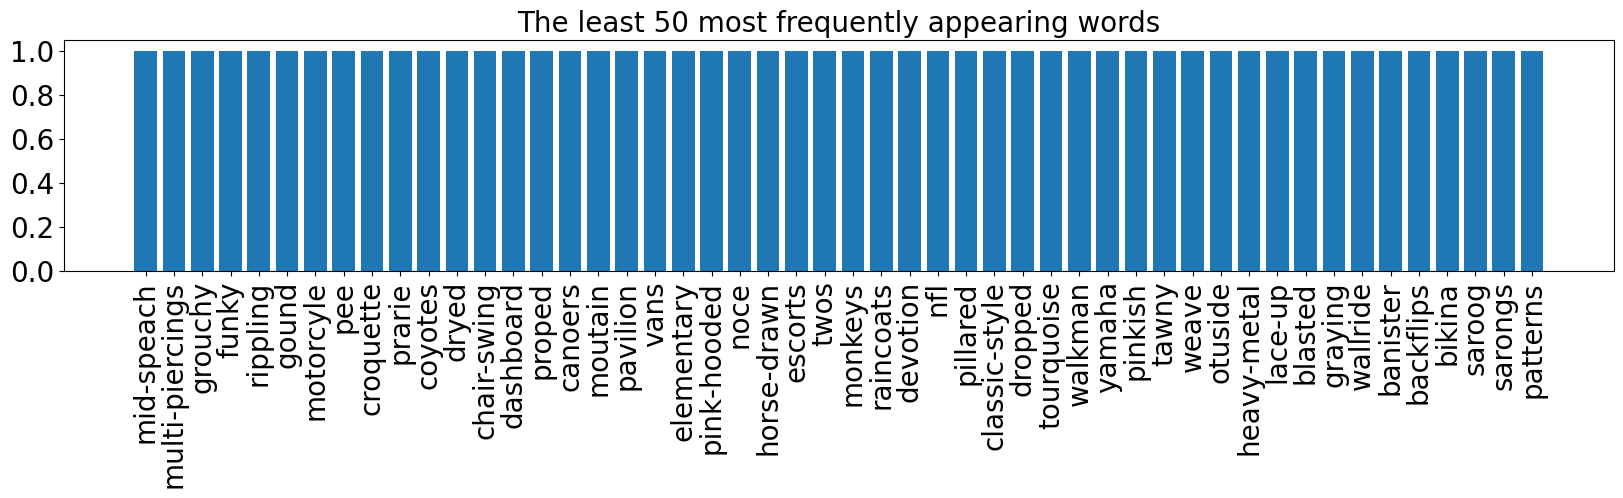

In [20]:
topn = 50

# plt: matlab's plyplot imported previously
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

INFERENCE: The most common words are articles such as "a", or "the", or punctuations.

In order to clean the caption so that it doesn't affect the model performance (because, sometimes these words can make the model baised), We will create three functions that:

* remove punctuation
* remove single character
* remove numeric characters

#### Cleaning example string using these 3 functions

In [23]:
import string
text_original = "I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?

Remove punctuations..
I scored 21 in NLP but Akshat topped I have python v38 Its 420 pm Could you give us 20 on 20

Remove a single character word..
 scored 21 in NLP but Akshat topped have python v38 Its 420 pm Could you give us 20 on 20

Remove words with numeric values..
    scored     : True
    21         : False
    in         : True
    NLP        : True
    but        : True
    Akshat     : True
    topped     : True
    have       : True
    python     : True
    v38        : False
    Its        : True
    420        : False
    pm         : True
    Could      : True
    you        : True
    give       : True
    us         : True
    20         : False
    on         : True
    20         : False
 scored in NLP but Akshat topped have python Its pm Could you give us on


### Cleaning all captions in dataset

Using the 3 functions, we will clean all captions

In [25]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

After cleaning our vocabulary size is significantly reduced by around 200 words.

#### Now, after cleaning the caption list of 50 most occurring and least occurring words

Vocabulary Size: 8763


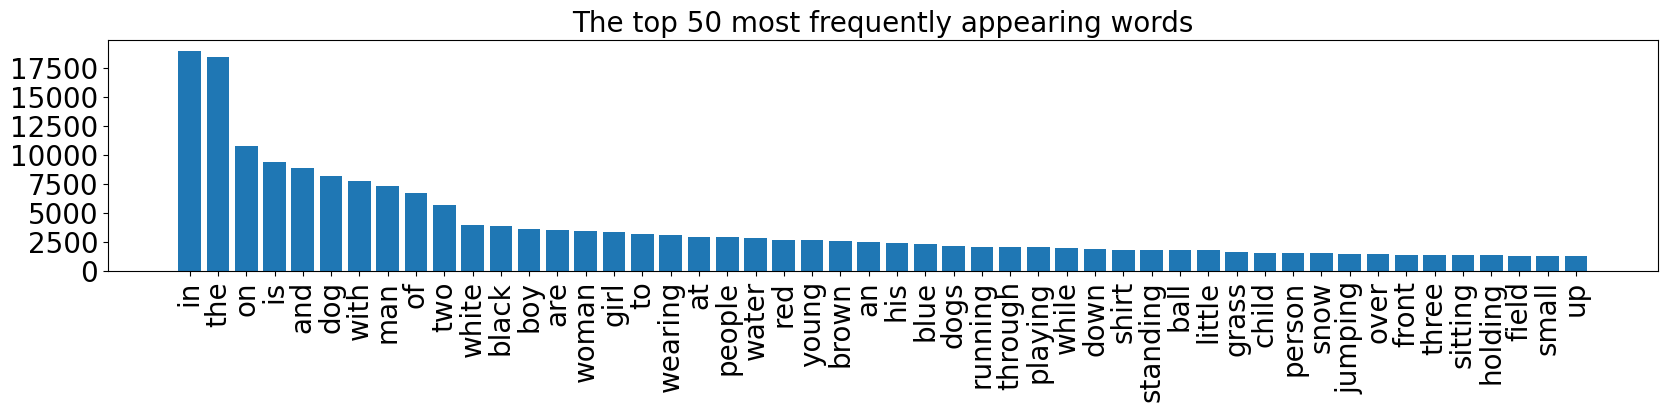

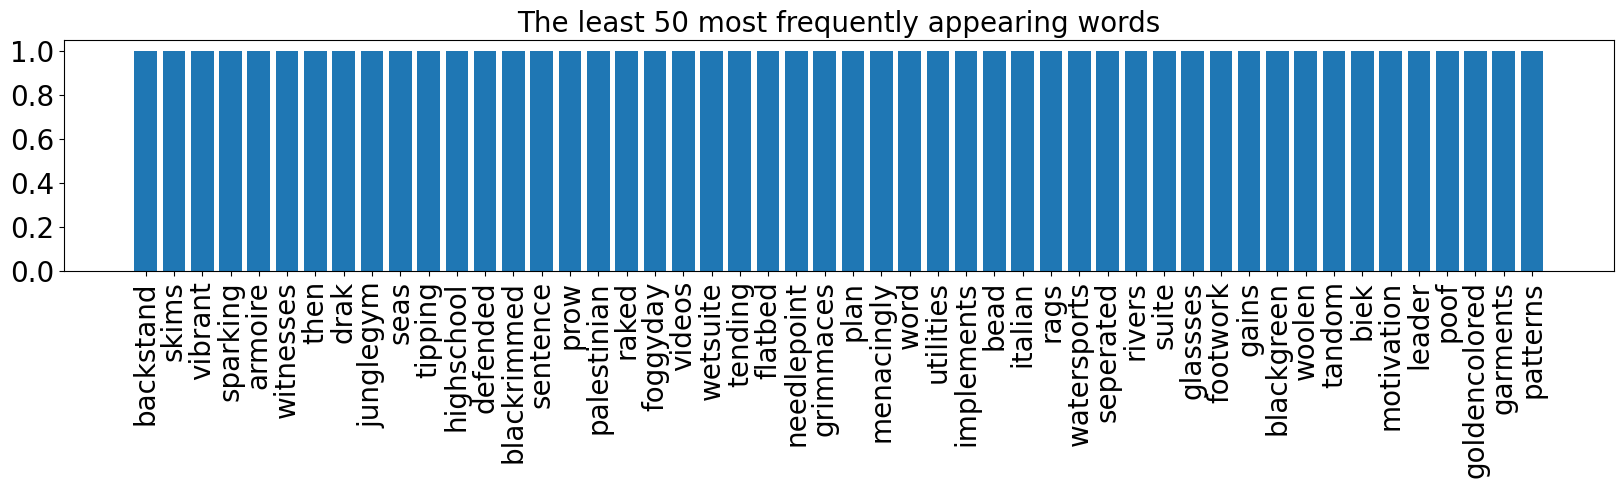

In [27]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

### Adding Start and End sequence tokens in every caption

In [29]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

## Image Preparation for the VGG16 Model

We will be using pre-trained network VGG16. This model takes input image of size (224, 224, 3).

We choose this model because it achieves 92.7% (top-5 test accuracy) in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

#### Double-click __here__ for the source of Model.

<!--
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
-->

In [33]:
modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)
## load the locally saved weights 
modelvgg.load_weights(r"/Users/arjunpesaru/Desktop/sml_p/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

__VGG16 is developed to classify images into 1,000 different classes. As we are not using VGG16 for the sake of the classification but we just need it for extracting features, we will remove the last layer from the network.__

In [35]:
modelvgg.layers.pop()
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
## show the deep learning model
modelvgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

### Transforming images to features using model

In [37]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from tensorflow.keras.models import load_model

# OrderDict(): is a dictionary subclass that remembers the order that keys were first inserted
images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs[:1000]):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [38]:
images['1000268201_693b08cb0e.jpg']

KeyError: '1000268201_693b08cb0e.jpg'

In [70]:
len(images)

1000

### Linking the text and image data

In [73]:
# extraction 1 caption for each 8091 images in dcaptions instead of 5 captions
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
# dimages: taken all 4096 features of each images respectively
dimages = np.array(dimages)

In [75]:
# 4096 features for all 8091 images

dimages.shape

(1000, 4096)

In [77]:
# List of caption for each image

dcaptions[:5]

array(['startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  black and white dog is running in grassy garden surrounded by white fence endseq',
       'startseq  man uses ice picks and crampons to scale ice endseq',
       'startseq  black dog carries green toy in his mouth as he walks through the grass endseq',
       'startseq  tent is being set up on the ice endseq'], dtype=object)

## Tokenizer

Our model doesn't understand the language of captions, so we have to tokenize it.
Changing character vector to integer vector/tokens

In [80]:
# using keras.preprocessing.text as tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

# Set the maximum number of words in the dictionary
nb_words = 8000

tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)

vocabulary size : 1537


In [82]:
# dtexts contains dcaptions but in token/integer form which looks like
# 1: for startseq
# 2: endseq
dtexts[:5]

[[1, 44, 15, 140, 3, 207, 93, 3, 39, 9, 274, 463, 11, 55, 149, 3, 709, 2],
 [1, 12, 6, 14, 5, 8, 32, 3, 85, 464, 465, 52, 14, 179, 2],
 [1, 10, 710, 166, 466, 6, 711, 17, 712, 166, 2],
 [1, 12, 5, 191, 45, 121, 3, 24, 63, 46, 180, 113, 35, 4, 40, 2],
 [1, 467, 8, 181, 236, 53, 7, 4, 166, 2]]

### Spliting the dataset in training and testing

In [85]:
# We will split the dataset in ratio 6:2:2 (train:valid:test)

prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

#  spliting captions text
dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
#  spliting images
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [87]:
# We need maxlen because keras layer takes input of all the sequences of same length.
# Hence to do the padding we need maximum length in caption

maxlen = np.max([len(text) for text in dtexts])

In [89]:
from keras.utils import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 600
 (6118, 29) (6118, 4096) (6118, 1537)
# captions/images = 200
 (2042, 29) (2042, 4096) (2042, 1537)


In [91]:
# First caption (dt_train[0]) represented in Xtext_train

Xtext_train[:14]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   1,  88],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,  88,  44],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         88,  44,  64],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  88,
         44,  64,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  88,  44,
    

In [93]:
# For each word (49631 words excluding start token) there is a image associated with it
# Image will be same for all words in a caption (i.e. if caption length is 14 Ximage_train[0] = Ximage_train[13])

Ximage_train.shape

(6118, 4096)

In [95]:
# Words one-hot encoding (vocab-size = 4476)

ytext_train.shape

(6118, 1537)

## Model

In [98]:
Ximage_train.shape[1]

4096

In [100]:
from tensorflow.keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

## sequence model
input_txt = layers.Input(shape=(maxlen,))
### The embedding layer in Keras can be used when we want to create the embeddings to embed higher dimensional data into lower dimensional vector space.
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)

## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = tf.keras.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

1537


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 29, 64)    │     98,368 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 29)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CaptionFeature      │ (None, 256)       │    328,704 │ embedding[0][0],  │
│ (LSTM)              │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageFeature        │ (None, 256)       │  1,048,832 │ input_layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ CaptionFeature[0… │
│                     │                   │            │ ImageFeature[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1537)      │    395,009 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,936,705 (7.39 MB)

 Trainable params: 1,936,705 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

None


__We are giving our model an image and a word (Ximage_train & Xtext_train respectively) and we want it to predict the next word for it which is our target ytext_train__

In [103]:
# Example: Here we are giving one image and a start-word and we want to predict next word.
# The next word is in our target which is 75.

print(Ximage_train[0])
print(Xtext_train[0])
# print(ytext_train[0][75])

[1.5410626 3.4735396 0.        ... 0.        4.468867  1.4303867]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [105]:
# fit model
start = time.time()

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
    
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5
96/96 - 6s - 62ms/step - loss: 5.8453 - val_loss: 5.5833
Epoch 2/5
96/96 - 6s - 62ms/step - loss: 4.9855 - val_loss: 5.5725
Epoch 3/5
96/96 - 6s - 66ms/step - loss: 4.3691 - val_loss: 5.5685
Epoch 4/5
96/96 - 7s - 69ms/step - loss: 3.7159 - val_loss: 5.7190
Epoch 5/5
96/96 - 7s - 78ms/step - loss: 3.1397 - val_loss: 5.9292
TIME TOOK 0.54MIN


In [106]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(6118, 4096) (6118, 29) (6118, 1537)


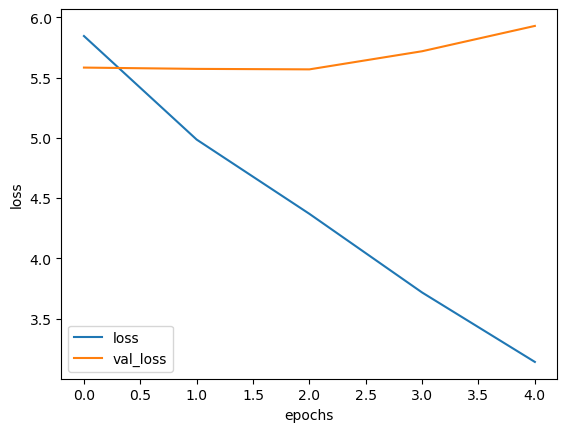

In [109]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

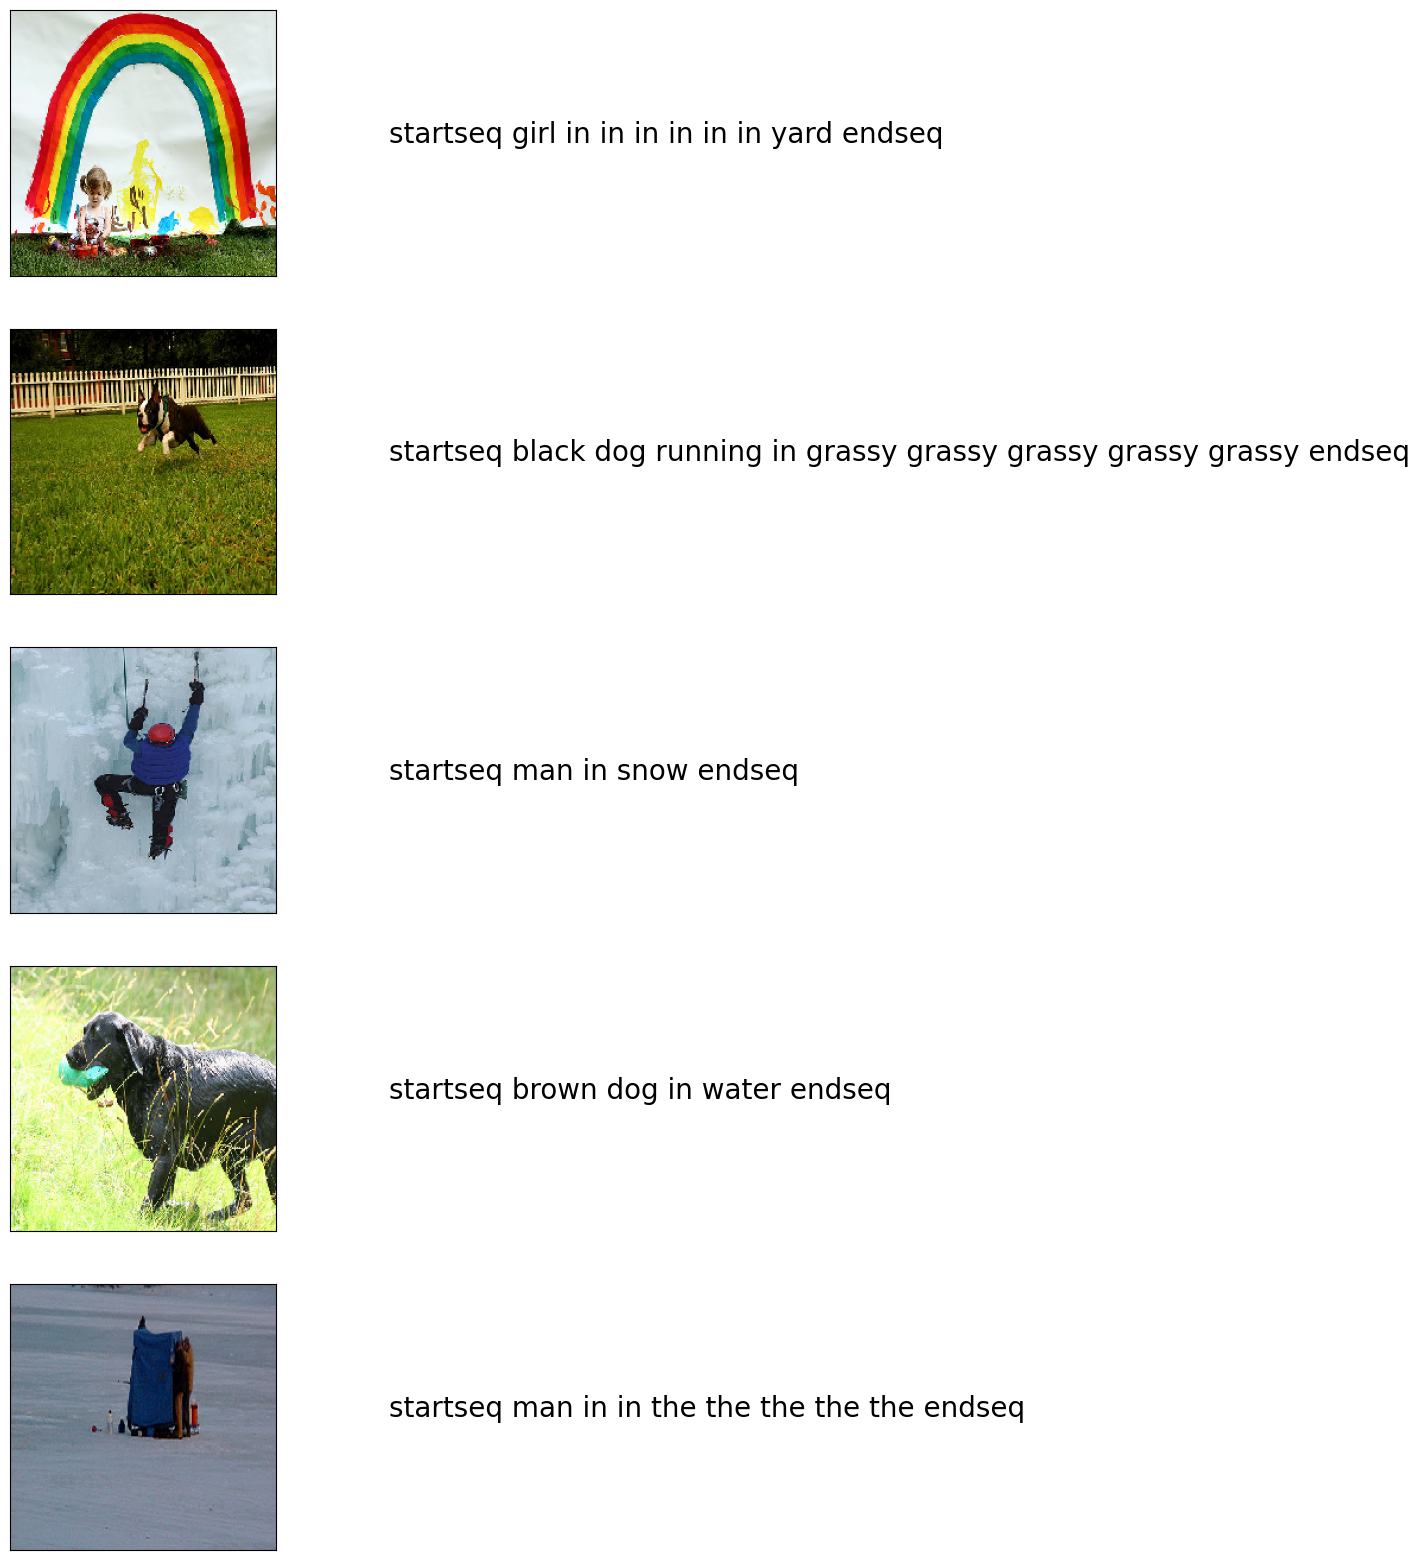

In [111]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
# prediction function
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [113]:
images['1000268201_693b08cb0e.jpg'].shape

KeyError: '1000268201_693b08cb0e.jpg'

## BLEU SCORE

In [120]:
# !pip install --upgrade nltk
start = time.time()

from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

smoothie = SmoothingFunction().method4
nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    bleu = sentence_bleu([caption_true],caption,smoothing_function=smoothie)
    bleus.append(bleu)
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
        
end = time.time()
print((start-end)/60)

  100.00% is done..
-0.9492874145507812


In [122]:
pred_good

[]

In [124]:
pred_bad[:2]

[(0.014879239542171468,
  '1002674143_1b742ab4b8.jpg',
  ['little',
   'girl',
   'covered',
   'in',
   'paint',
   'sits',
   'in',
   'front',
   'of',
   'painted',
   'rainbow',
   'with',
   'her',
   'hands',
   'in',
   'bowl'],
  ['girl', 'in', 'in', 'in', 'in', 'in', 'in', 'yard']),
 (0.10526970250674395,
  '1009434119_febe49276a.jpg',
  ['black',
   'and',
   'white',
   'dog',
   'is',
   'running',
   'in',
   'grassy',
   'garden',
   'surrounded',
   'by',
   'white',
   'fence'],
  ['black',
   'dog',
   'running',
   'in',
   'grassy',
   'grassy',
   'grassy',
   'grassy',
   'grassy'])]

In [126]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.022


Bad Caption


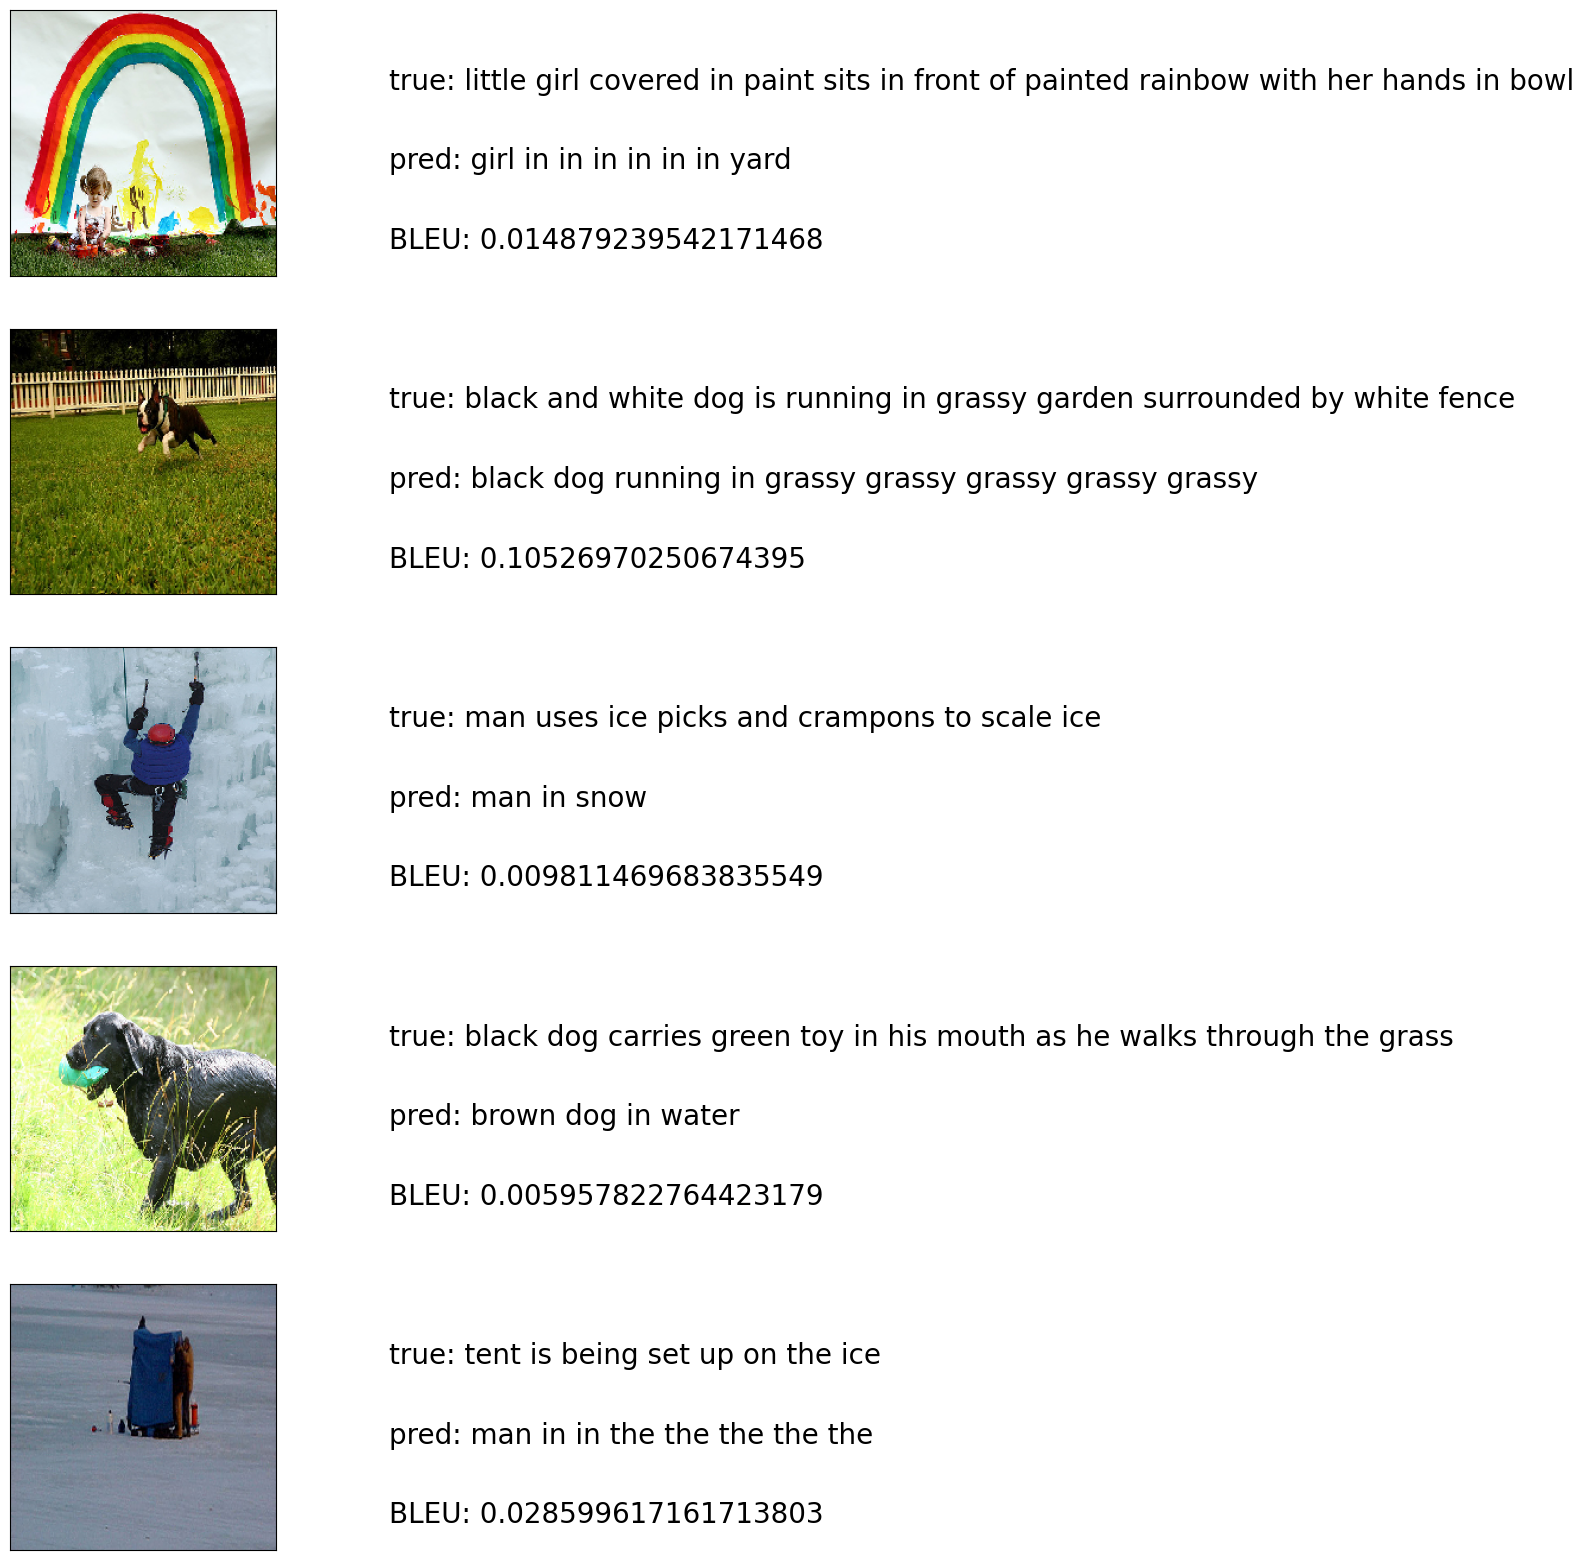

Good Caption


<Figure size 1000x2000 with 0 Axes>

In [128]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

## GUI

In [131]:
# Importing libraries

import tkinter as tk
from PIL import Image, ImageTk
from tkinter import filedialog

In [133]:
import os

os.chdir(r'/Users/arjunpesaru/Desktop/sml_p')
os.getcwd()

'/Users/arjunpesaru/Desktop/sml_p'

In [135]:
def upload_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()

    image_data = filedialog.askopenfilename(initialdir="/", title="Choose an image",
                                       filetypes=(("all files", "*.*"), ("png files", "*.png")))
    basewidth = 300
    img = Image.open(image_data)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    file_name = image_data.split('/')
    panel = tk.Label(frame, text= str(file_name[len(file_name)-1]).upper()).pack()
    panel_image = tk.Label(frame, image=img).pack()
    
def caption():
    
    original = Image.open(image_data)
    original = original.resize((224, 224), Image.ANTIALIAS)
    numpy_image = img_to_array(original)
    nimage = preprocess_input(numpy_image)
    
    feature = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    caption = predict_caption(feature)
    table = tk.Label(frame, text="Caption: " + caption[9:-7], font=("Helvetica", 12)).pack()

In [137]:
root = tk.Tk()
root.title('IMAGE CAPTION GENERATOR')
root.iconbitmap('class.ico')
root.resizable(False, False)
tit = tk.Label(root, text="IMAGE CAPTION GENERATOR", padx=25, pady=6, font=("", 12)).pack()
canvas = tk.Canvas(root, height=550, width=600, bg='#D1EDf2')
canvas.pack()
frame = tk.Frame(root, bg='white')
frame.place(relwidth=0.8, relheight=0.8, relx=0.1, rely=0.1)
chose_image = tk.Button(root, text='Choose Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=upload_img, activebackground="#add8e6")
chose_image.pack(side=tk.LEFT)

caption_image = tk.Button(root, text='Classify Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=caption, activebackground="#add8e6")
caption_image.pack(side=tk.RIGHT)
root.mainloop()

2024-12-05 16:48:12.037 python[26807:4155534] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-05 16:48:12.037 python[26807:4155534] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2024-12-05 16:48:15.464 python[26807:4155534] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
Exception in Tkinter callback
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/tkinter/__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/_b/9lwhr4qd16z36wvsl1mm5d5w0000gn/T/ipykernel_26807/1523009455.py", line 12, in upload_img
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
                                         ^^^^^^^^^^^^^^^
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'
Exception in Tkinter callback
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/tkinter/__init__.py", line 1968, in __call__
    return